In [53]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [54]:
from b2heavy.FnalHISQMetadata import params as mData

In [55]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites, ratio_correction_factor
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [56]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'


BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [57]:
ENSEMBLE = 'Coarse-1'
RATIO    = 'QPLUS'
SMSLIST  = ['1S','RW']
# SMSLIST  = ['1S']
MOMLIST  = ['100','200','300','400']
MOMLIST  = ['100','200','300']
# MOMLIST  = ['000']

In [58]:
if RATIO in ['RMINUS','RPLUS','QPLUS','XF']:
    meson = 'D'
else:
    meson = 'Dst'

In [59]:
TMIN    = 1
NSTATES = 2

In [60]:
JK = True

# ---------- chi^2_exp analysis -------------
# chi2_exp = 22.000000000000284 +/- 6.633249580711021 
# p-value [eval] = 0.8106
# p-value [MC]   = 0.7983
# ---------- 2+2 fit in (1, 11) for mes: QPLUS of ens: Coarse-1 for mom: 100 --------------
Least Square Fit:
  chi2/dof [dof] = 0.41 [22]    Q = 0.99    logGBF = 99.727

Parameters:
        ratio 0    0.9886 (31)      [  0.99 (10) ]  
         A_1S 0      0.10 (13)      [    0 ± 1.0 ]  
              1    -0.038 (14)      [    0 ± 1.0 ]  
         B_1S 0     -0.34 (64)      [    0 ± 1.0 ]  
              1    0.0152 (54)      [    0 ± 1.0 ]  
         A_RW 0     0.013 (31)      [    0 ± 1.0 ]  
              1   -0.0092 (69)      [    0 ± 1.0 ]  
         B_RW 0     -0.18 (35)      [    0 ± 1.0 ]  
              1    0.0097 (46)      [    0 ± 1.0 ]  
       dE_src 0      1.09 (49)      [  1.02 (50) ]  
              1     -0.35 (35)      [ -0.68 (50) ]  
       dE_snk 0      1.72 (35)      [  1.92 (50) ]  
              1     -1.01 (4

Text(0.5, 1.0, 'Coarse-1 QPLUS')

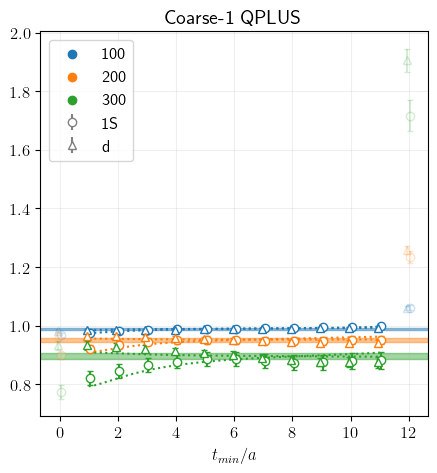

In [61]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,1,figsize=(5,5))

fits = []
f0s = []
for i,mom in enumerate(MOMLIST):
    requisites = ratio_prerequisites(
        ens      = ENSEMBLE,
        ratio    = RATIO,
        mom      = mom,
        readfrom = DATA_2PT,
        jk       = JK
    )

    io = RatioIO(ENSEMBLE,RATIO,mom,PathToDataDir=DATA_DIR)
    robj = RatioFitter(
        io,
        jkBin     = BINSIZE[ENSEMBLE],
        smearing  = SMSLIST,
        # readfrom  = DATA_2PT,
        **requisites
    )

    trange = (TMIN, robj.Ta-TMIN)

    cov_specs = dict(
        diag   = False,
        block  = False,
        scale  = True,
        shrink = True,
        cutsvd = 1E-12
    )

    dE_src = phys_energy_priors(ENSEMBLE,meson,mom,NSTATES,readfrom=DATA_2PT, error=0.5)
    dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,mom,NSTATES,readfrom=DATA_2PT, error=0.5)
    x,ydata = robj.format(trange,flatten=True)
    pr = robj.priors(NSTATES, dE_src=dE_src, dE_snk=dE_snk)

    fit = robj.fit(
        Nstates = NSTATES,
        trange  = trange,
        priors  = pr,
        verbose = False,
        **cov_specs
    )

    res = robj.fit_result(
        Nexc   = NSTATES,
        trange = trange,
        priors = pr 
    )

    fits.append({
        'ensemble': ENSEMBLE,
        'ratio'   : RATIO,
        'momentum': mom,
        'f0'      : fit.p['ratio'][0],
        'chiexp'  : res['chiexp'],
        'pstd'    : res['pstd']
    })


    alpha = 0.2 if mom=='400' else 1.
    robj.plot_fit(ax,NSTATES,trange,color=f'C{i}',color_res=f'C{i}',alpha=alpha,minus=False)

    ax.scatter([],[], marker='o', color=f'C{i}', label=mom)


    f0s.append(fit.p['ratio'][0])

ax.errorbar([],[],[],fmt='o', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='1S')
ax.errorbar([],[],[],fmt='^', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='d')

# ax.set_xlim(-0.5,13)
# ax.set_ylim(ymax=0.35,ymin=0.)
ax.grid(alpha=0.2)
ax.legend()

ax.set_xlabel(r'$t_{min}/a$')

ax.set_title(f'{ENSEMBLE} {RATIO}')

# ax.set_ylabel(r'$Q_+$')
# ax.set_ylabel(r'abs($x_f$)')


# plt.savefig(f'/Users/pietro/Desktop/{ENSEMBLE}_{RATIO}_multimom.pdf')

In [62]:
print(pd.DataFrame(fits).set_index(['ensemble','ratio','momentum']))

                                 f0  chiexp      pstd
ensemble ratio momentum                              
Coarse-1 QPLUS 100       0.9886(31)    22.0  0.614128
               200       0.9519(62)    22.0  0.170011
               300        0.896(11)    22.0  0.071194
